In [1]:
# tester for c++ version of igrf model
# check whether we get the same contour plot as the 2015 IGRF model for the total intensity
# from the IGRF 12th generation paper
import sys, os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "gtracr"))

# from gtracr.trajectory import Trajectory
from gtracr.lib._libgtracr import IGRF

In [2]:
# instantiate IGRF model with current date
DATA_DIR = os.path.join(os.getcwd(), "..", "..", "..", "data")
DATA_PATH = os.path.join(DATA_DIR, "igrf13.json")

current_year = 2015

igrf = IGRF(DATA_PATH, current_year)

In [3]:
# check if things are working correctly
print(igrf.sdate)  # should return current date
print(igrf.nmax)
print(igrf.gh_coeffs)

2015.0
13
[-1501.77, 4795.99, -2445.88, 3012.2, -2845.41, 1676.35, -642.17, 1350.33, -2352.26, -115.29, 1225.85, 245.04, 581.69, -538.7, 907.42, 813.68, 283.54, 120.49, -188.43, -334.85, 180.95, 70.38, -329.23, -232.91, 360.14, 46.98, 192.35, 196.98, -140.94, -119.14, -157.4, 15.98, 4.3, 100.12, 69.55, 67.57, -20.61, 72.79, 33.3, -129.85, 58.74, -28.93, -66.64, 13.14, 7.35, -70.85, 62.41, 81.29, -75.99, -54.27, -6.79, -19.53, 51.82, 5.59, 15.07, 24.45, 9.32, 3.27, -2.88, -27.5, 6.61, -2.32, 23.98, 8.89, 10.04, -16.78, -18.26, -3.16, 13.18, -20.56, -14.6, 13.33, 16.16, 11.76, 5.69, -15.98, -9.1, -2.02, 2.26, 5.33, 8.83, -21.77, 3.02, 10.76, -3.22, 11.74, 0.67, -6.74, -13.2, -6.88, -0.1, 7.79, 8.68, 1.04, -9.06, -3.89, -10.54, 8.44, -2.01, -6.26, 3.28, 0.17, -0.4, 0.55, 4.55, -0.55, 4.4, 1.7, -7.92, -0.67, -0.61, 2.13, -4.16, 2.33, -2.85, -1.8, -1.12, -3.59, -8.72, 3.0, -1.4, 0.0, -2.3, 2.11, 2.08, -0.6, -0.79, -1.05, 0.58, 0.76, -0.7, -0.2, 0.14, -2.12, 1.7, -1.44, -0.22, -2.57, 0.44, -

In [4]:
# obtain the magnetic field components
EARTH_RADIUS = 6.3712 * (1e6)
num = 10000
r = EARTH_RADIUS   # start with constant radius for now

result_arr = []

# in a Monte-Carlo like manner
for i in range(num):
    (theta, phi) = np.random.rand(2)
    theta *= np.pi
    phi = (phi * 2. *np.pi) - np.pi
#     print(r, theta, phi)
#     print(type(r), type(theta), type(phi))
    bf_values = igrf.values(r, theta, phi)
    bmag = np.linalg.norm(np.array(bf_values))
#     print(bmag)
    result_arr.append((theta, phi, bmag))
    

In [5]:
# print(igrf.cartesian_values[0])
print(bmag)

7683.52388896373


In [6]:
# get results in presentable format

# first for scatter plot
theta_arr, phi_arr, bmag_arr = zip(*result_arr)

lat_arr = 90. - (np.array(theta_arr) * (180. / np.pi))  # translate to get latitude values 
lng_arr = np.array(phi_arr) * (180. / np.pi)   # longitude follows [-180, 180] convention

# then for contour plots
# create matrix elements of lat, lng


from scipy.interpolate import griddata
# perfect for linear!
ngrid_lat = 70
ngrid_lng = 70


# ngrid_azimuth =50
# ngrid_zenith = 50

lng_grid = np.linspace(
    np.min(lng_arr),
    np.max(lng_arr), ngrid_lng)
lat_grid = np.linspace(
    np.min(lat_arr),
    np.max(lat_arr), ngrid_lat)

# triang = tri.Triangulation(azimuth_arr, zenith_arr)
# interpolator = tri.LinearTriInterpolator(triang, rigidity_cutoffarr)
# azimuth_matrix, zenith_matrix = np.meshgrid(azimuth_grid, zenith_grid)
# rigidity_cutoffgrid = interpolator(azimuth_matrix, zenith_matrix)

bmag_grid = griddata(points=(lng_arr, lat_arr),
                               values=bmag_arr,
                               xi=(lng_grid[None, :],
                                   lat_grid[:, None]),
                               method='linear')

(-90.0, 90.0)

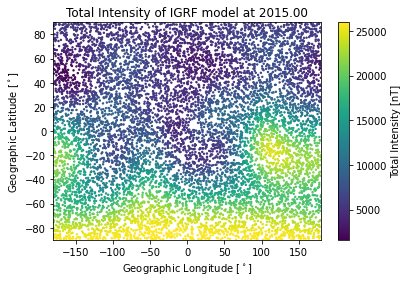

In [7]:
# plot the scatter plot
fig1, ax1 = plt.subplots(figsize=(6,4))
im1 = ax1.scatter(lng_arr, lat_arr, c=bmag_arr, s=2.0)
ax1.set_xlabel(r"Geographic Longitude [$^\circ$]")
ax1.set_ylabel(r"Geographic Latitude [$^\circ$]")
ax1.set_title("Total Intensity of IGRF model at {:.2f}".format(current_year))

cbar = fig1.colorbar(im1, ax=ax1)
cbar.ax.set_ylabel("Total Intensity [nT]")

ax1.set_xlim([-180., 180.])
ax1.set_ylim([-90., 90.])


Text(0.5, 1.0, "Total Intensity of Earth's Magnetic Field at r = 6371.2km in 2015")

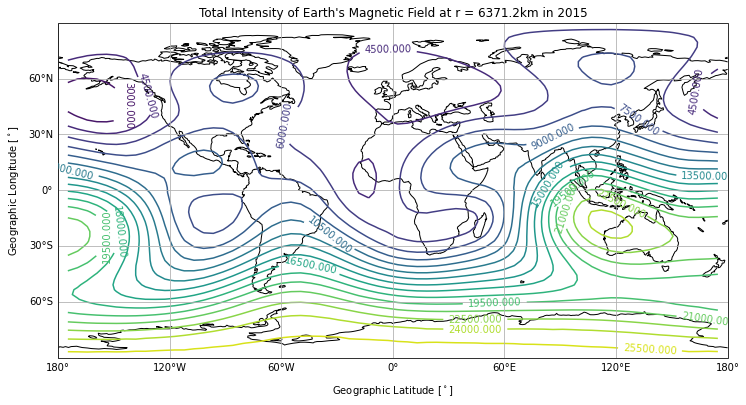

In [8]:
'''
Below is for contour plots with colored lines
with world map using cartopy
'''

level_len=18

# using cartopy to plot with world map in background
# to install this in ubuntu, the following procedure is required:
# apt-get install libproj-dev proj-data proj-bin  
# apt-get install libgeos-dev  
# pip install cython  
# pip install cartopy  
# a bit of a hassle but required if we want to plot world maps
# regularly, otherwise add this as an optional dependency
# to our package

from cartopy import crs as ccrs

fig = plt.figure(figsize=(12,9))
map_type = ccrs.PlateCarree()   # rectangular map
ax = plt.axes(projection=map_type)

# set extent of the plot to be full range
ax.set_extent([-180., 180., -90., 90.], map_type)
# draw the coastlines of the world
ax.coastlines()   
# draw the grid lines onto the axes
# and modify with options
# dms : enable dms notation or not
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels = False   # remove top labels
gl.right_labels = False   # remove right labels
ax.text(-0.055, 0.5, "Geographic Longitude [$^\circ$]", va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.12, "Geographic Latitude [$^\circ$]", va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)


contour = ax.contour(
    lng_grid,
    lat_grid,
    bmag_grid,
    #  levels=rigidity_list,
#     colors="k",
    cmap="viridis",
    linewidths=1.5,
#     extent=[-5., 365., -5., 185.], 
#      extent=[0., 360., 0., 180.],
#     corner_mask=False,
    levels=level_len,
    alpha=1.
)
# # divider = make_axes_locatable(ax)
# # cax = divider.append_axes("right", size="5%", pad=0.1)

ax.clabel(contour, inline=1, fontsize=10.0)

ax.set_xlabel("Geographic Longitude [$^\circ$]")
ax.set_ylabel("Geographic Latitude [$^\circ$]")
ax.set_title("Total Intensity of Earth's Magnetic Field at r = {:.1f}km in {:d}".format(
    r*(1e-3), current_year))

# fig.tight_layout()

Text(0.5, 1.0, "Total Intensity of Earth's Magnetic Field at r = 6371.2km in 2015")

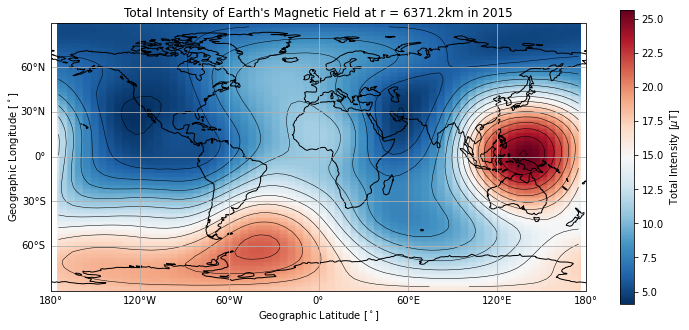

In [14]:
'''
Below is for contour plots with colored lines
with world map using cartopy
'''

# using cartopy to plot with world map in background
# to install this in ubuntu, the following procedure is required:
# apt-get install libproj-dev proj-data proj-bin  
# apt-get install libgeos-dev  
# pip install cython  
# pip install cartopy  
# a bit of a hassle but required if we want to plot world maps
# regularly, otherwise add this as an optional dependency
# to our package

from cartopy import crs as ccrs

fig = plt.figure(figsize=(12,9))
# create axes with different world map type
# as the projection
# list of projections: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
map_type = ccrs.PlateCarree()  
ax = plt.axes(projection=map_type)

# set extent of the plot
ax.set_extent([-180., 180., -90., 90.], map_type)
ax.coastlines()   # draw the coastlines of the world
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels = False   # remove top labels
gl.right_labels = False   # remove right labels

# the tick labels are used instead of name labels with cartopy
# as such, there is no nice feature to add name labels in axes
# as such, one has to resort to adding text to the axes 
# with manually setting the location of the text
# obtained from stack overflow: https://stackoverflow.com/questions/35479508/cartopy-set-xlabel-set-ylabel-not-ticklabels
ax.text(-0.055, 0.5, "Geographic Longitude [$^\circ$]", va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.12, "Geographic Latitude [$^\circ$]", va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)

image = ax.imshow(
    bmag_grid * (1e-3),
    extent=[-185., 185., -95., 95.], 
#     extent=[0., 360., 0., 180.],
#     extent=[-1, 361, -1, 181],
    origin='lower',
    cmap="RdBu_r",
    interpolation="bicubic",
    aspect="auto",
    vmin=np.min(bmag_arr)* (1e-3),
    vmax=np.max(bmag_arr)* (1e-3),
    alpha=1.
)
ax.axis('image')

cbar = fig.colorbar(image, ax=ax, shrink=0.6)
cbar.ax.set_ylabel(r"Total Intensity [$\mu$T]")

contour = ax.contour(
    lng_grid,
    lat_grid,
    bmag_grid,
    #  levels=rigidity_list,
    colors="k",
#     cmap="viridis",
    linewidths=0.5,
#     extent=[-5., 365., -5., 185.], 
#      extent=[0., 360., 0., 180.],
#     corner_mask=False,
#     extent=[-182.5, 182.5, -92.5, 92.5], 
    extent=[-180., 180., -90., 90.], 
    levels=level_len,
    alpha=1.
)

# cbar.set_clim([np.min(rigidity_list)-0.5, np.max(rigidity_list)+0.5])
# cbar.ax.set_ylim([np.min(rigidity_list)-0.5, np.max(rigidity_list)+0.5])

# ax.set_xlim([-180., 180.])
# ax.set_ylim([0., 180.])

# ax.set_xlabel("Geographic Longitude [$^\circ$]")
# ax.set_ylabel("Geographic Latitude [$^\circ$]")
ax.set_title("Total Intensity of Earth's Magnetic Field at r = {:.1f}km in {:d}".format(
    r*(1e-3), current_year))

# fig.tight_layout()